In [1]:
import pathlib
import timeit

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chemfiles import Frame, Trajectory

import znh5md

In [2]:
N_ATOMS = np.logspace(1, 4.5, 20, dtype=int)
N_STEPS = 100

In [3]:
H5MD_FILE = pathlib.Path("test.h5")
XYZ_FILE = pathlib.Path("test.xyz")
PDB_FILE = pathlib.Path("test.pdb")

In [4]:
znh5md_write_times = []
znh5md_read_times = []

ase_xyz_write_times = []
ase_xyz_read_times = []

chemfiles_pdb_write_times = []
chemfiles_pdb_read_times = []


def write_chemfiles_pdb(frames):
    with Trajectory(PDB_FILE.as_posix(), "w") as traj:
        for frame in frames:
            traj.write(frame)


def read_chemfiles_pdb():
    with Trajectory(PDB_FILE.as_posix(), "r") as traj:
        for frame in traj:
            # access to actually read the data?
            _ = frame.positions


for n_atoms in N_ATOMS:
    images = []
    frames = []
    # remove test.h5 if it exists
    if H5MD_FILE.exists():
        H5MD_FILE.unlink()
    if XYZ_FILE.exists():
        XYZ_FILE.unlink()
    if PDB_FILE.exists():
        PDB_FILE.unlink()
    for n in range(N_STEPS):
        atoms = ase.Atoms("H" * n_atoms, positions=np.random.rand(n_atoms, 3))
        images.append(atoms)
        frame = Frame()
        frame.resize(n_atoms)
        frame.positions[:] = atoms.positions
        frames.append(frame)
    print(f" ---- {n_atoms = } ----")
    znh5md_write_times.append(
        timeit.timeit(lambda: znh5md.write(H5MD_FILE, images), number=1)
    )
    znh5md_read_times.append(
        timeit.timeit(
            lambda: znh5md.read(H5MD_FILE, index=slice(None, None, None)), number=1
        )
    )

    ase_xyz_write_times.append(
        timeit.timeit(lambda: ase.io.write(XYZ_FILE, images, format="xyz"), number=1)
    )
    ase_xyz_read_times.append(
        timeit.timeit(
            lambda: ase.io.read(XYZ_FILE, index=slice(None, None, None)), number=1
        )
    )

    chemfiles_pdb_write_times.append(
        timeit.timeit(lambda: write_chemfiles_pdb(frames), number=1)
    )

    chemfiles_pdb_read_times.append(
        timeit.timeit(lambda: read_chemfiles_pdb(), number=1)
    )

 ---- n_atoms = 10 ----
 ---- n_atoms = 15 ----
 ---- n_atoms = 23 ----
 ---- n_atoms = 35 ----
 ---- n_atoms = 54 ----
 ---- n_atoms = 83 ----
 ---- n_atoms = 127 ----
 ---- n_atoms = 194 ----
 ---- n_atoms = 297 ----
 ---- n_atoms = 454 ----
 ---- n_atoms = 695 ----
 ---- n_atoms = 1062 ----
 ---- n_atoms = 1623 ----
 ---- n_atoms = 2481 ----
 ---- n_atoms = 3792 ----
 ---- n_atoms = 5796 ----
 ---- n_atoms = 8858 ----
 ---- n_atoms = 13538 ----
 ---- n_atoms = 20691 ----
 ---- n_atoms = 31622 ----


In [5]:
df = pd.DataFrame(
    {
        "znh5md:write": znh5md_write_times,
        "znh5md:read": znh5md_read_times,
        "ase:xyz:write": ase_xyz_write_times,
        "ase:xyz:read": ase_xyz_read_times,
        "chemfiles:pdb:write": chemfiles_pdb_write_times,
        "chemfiles:pdb:read": chemfiles_pdb_read_times,
    },
    index=N_ATOMS,
)

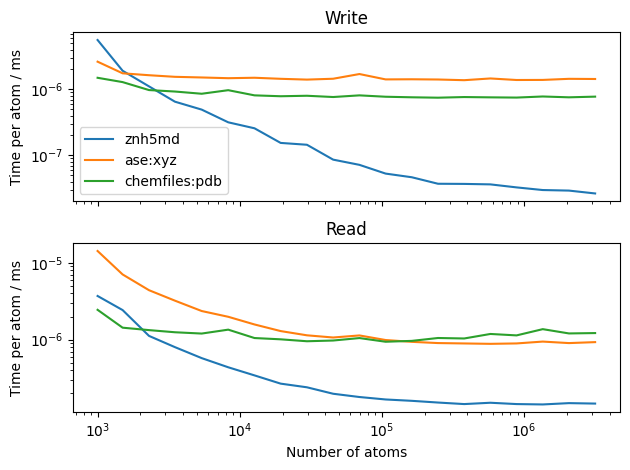

In [9]:
# two figures, one for write and one for read. Both values should be divided by the index
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].set_title("Write")
axes[0].plot(
    df.index * N_STEPS, df["znh5md:write"] / df.index / N_STEPS, label="znh5md"
)
axes[0].plot(
    df.index * N_STEPS, df["ase:xyz:write"] / df.index / N_STEPS, label="ase:xyz"
)
axes[0].plot(
    df.index * N_STEPS,
    df["chemfiles:pdb:write"] / df.index / N_STEPS,
    label="chemfiles:pdb",
)
axes[0].legend()
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_ylabel("Time per atom / ms")
# axes[0].set_xlabel("Number of atoms")

axes[1].set_title("Read")
axes[1].plot(df.index * N_STEPS, df["znh5md:read"] / df.index / N_STEPS, label="znh5md")
axes[1].plot(
    df.index * N_STEPS, df["ase:xyz:read"] / df.index / N_STEPS, label="ase:xyz"
)
axes[1].plot(
    df.index * N_STEPS,
    df["chemfiles:pdb:read"] / df.index / N_STEPS,
    label="chemfiles:pdb",
)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_ylabel("Time per atom / ms")
axes[1].set_xlabel("Number of atoms")
# axes[1].legend()
fig.tight_layout()
plt.savefig("benchmark.png")

In [10]:
H5MD_FILE.unlink()
XYZ_FILE.unlink()
PDB_FILE.unlink()